In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib
from lovely_tensors import monkey_patch
monkey_patch()
print("matplotlib version:", matplotlib.__version__)


matplotlib version: 3.9.2


In [2]:
from src.xil_research_modification.utils import XILUtils
device = XILUtils.define_device()

In [3]:
import torchvision.datasets as tds
from torchvision.transforms import Lambda
import torchvision.transforms.functional as torchvisionF

transform_func_device = Lambda(lambda i: torchvisionF.to_tensor(i).to(device=device))
ds_train = tds.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transform_func_device,
)

ds_test = tds.MNIST(
    root="data/",
    train=False,
    download=True,
    transform=transform_func_device,
)


### view data

In [15]:
from torch.utils.data import DataLoader

BS = 5
train_dl = DataLoader(ds_train, batch_size=BS)

train_dl_iter = iter(train_dl)

In [16]:
x_batch, y_batch = next(train_dl_iter)

In [17]:
x_batch, y_batch

(tensor[5, 1, 28, 28] n=3920 (15Kb) x∈[0., 1.000] μ=0.163 σ=0.338 mps:0,
 tensor[5, 2] n=10 x∈[0., 1.000] μ=0.500 σ=0.527 mps:0 [[1.000, 0.], [0., 1.000], [1.000, 0.], [0., 1.000], [1.000, 0.]])

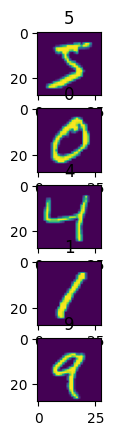

In [7]:
fig, axes = plt.subplots(5, 1)

for i in range(BS):
    axes[i].imshow(x_batch[i, 0].cpu(), cmap='viridis')
    axes[i].set_title(f"{y_batch[i]}")


In [8]:
import torch

train_dataset_length = -1

labels = [0, 8]
train_indices = [i for i, (_, label) in enumerate(ds_train) if label in labels][:train_dataset_length]
test_indices = [i for i, (_, label) in enumerate(ds_test) if label in labels]
ds_train = torch.utils.data.Subset(ds_train, train_indices)
ds_test = torch.utils.data.Subset(ds_test, test_indices)

# Set target_transform attribute
target_transform = Lambda(lambda y: torch.zeros(2, dtype=torch.float, device=device).scatter_(0, torch.tensor(0 if y == 0 else 1, device=device), value=1))
ds_train.dataset.target_transform = target_transform
ds_test.dataset.target_transform = target_transform


## Debugging Guided Backpropagation

In [76]:
from src.xil_research_modification.experiments.cnn import CNNTwoConv

model = CNNTwoConv(num_classes=2, device=device)

model.eval()

CNNTwoConv(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [77]:
# load state dict
from pathlib import Path
DIR = Path("08_MNIST_output/")
model.load_state_dict(torch.load(DIR / "confounded_ds_model.pth", weights_only=True))

<All keys matched successfully>

In [79]:
model(x_batch)

tensor[5, 2] n=10 x∈[-7.568, 9.138] μ=0.277 σ=6.938 grad LinearBackward0 mps:0 [[6.068, -7.231], [-5.249, 8.065], [6.363, -7.568], [-5.972, 9.138], [3.764, -4.606]]

In [13]:
from torch.nn import CrossEntropyLoss
loss = CrossEntropyLoss()

In [78]:
BS = 64
test_dl, train_dl = DataLoader(ds_test, batch_size=BS, shuffle=False), DataLoader(ds_train, batch_size=BS, shuffle=True)
XILUtils.test_loop(test_dl, model, loss, device)

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.022269 



In [80]:

guided_backprop_result = XILUtils.guided_backprop_explain(x_batch, y_batch, model, device, normalize=False)
print(f"{guided_backprop_result=}")

guided_backprop_result=tensor[5, 1, 28, 28] n=3920 (15Kb) x∈[-0.176, 0.621] μ=0.020 σ=0.061 mps:0


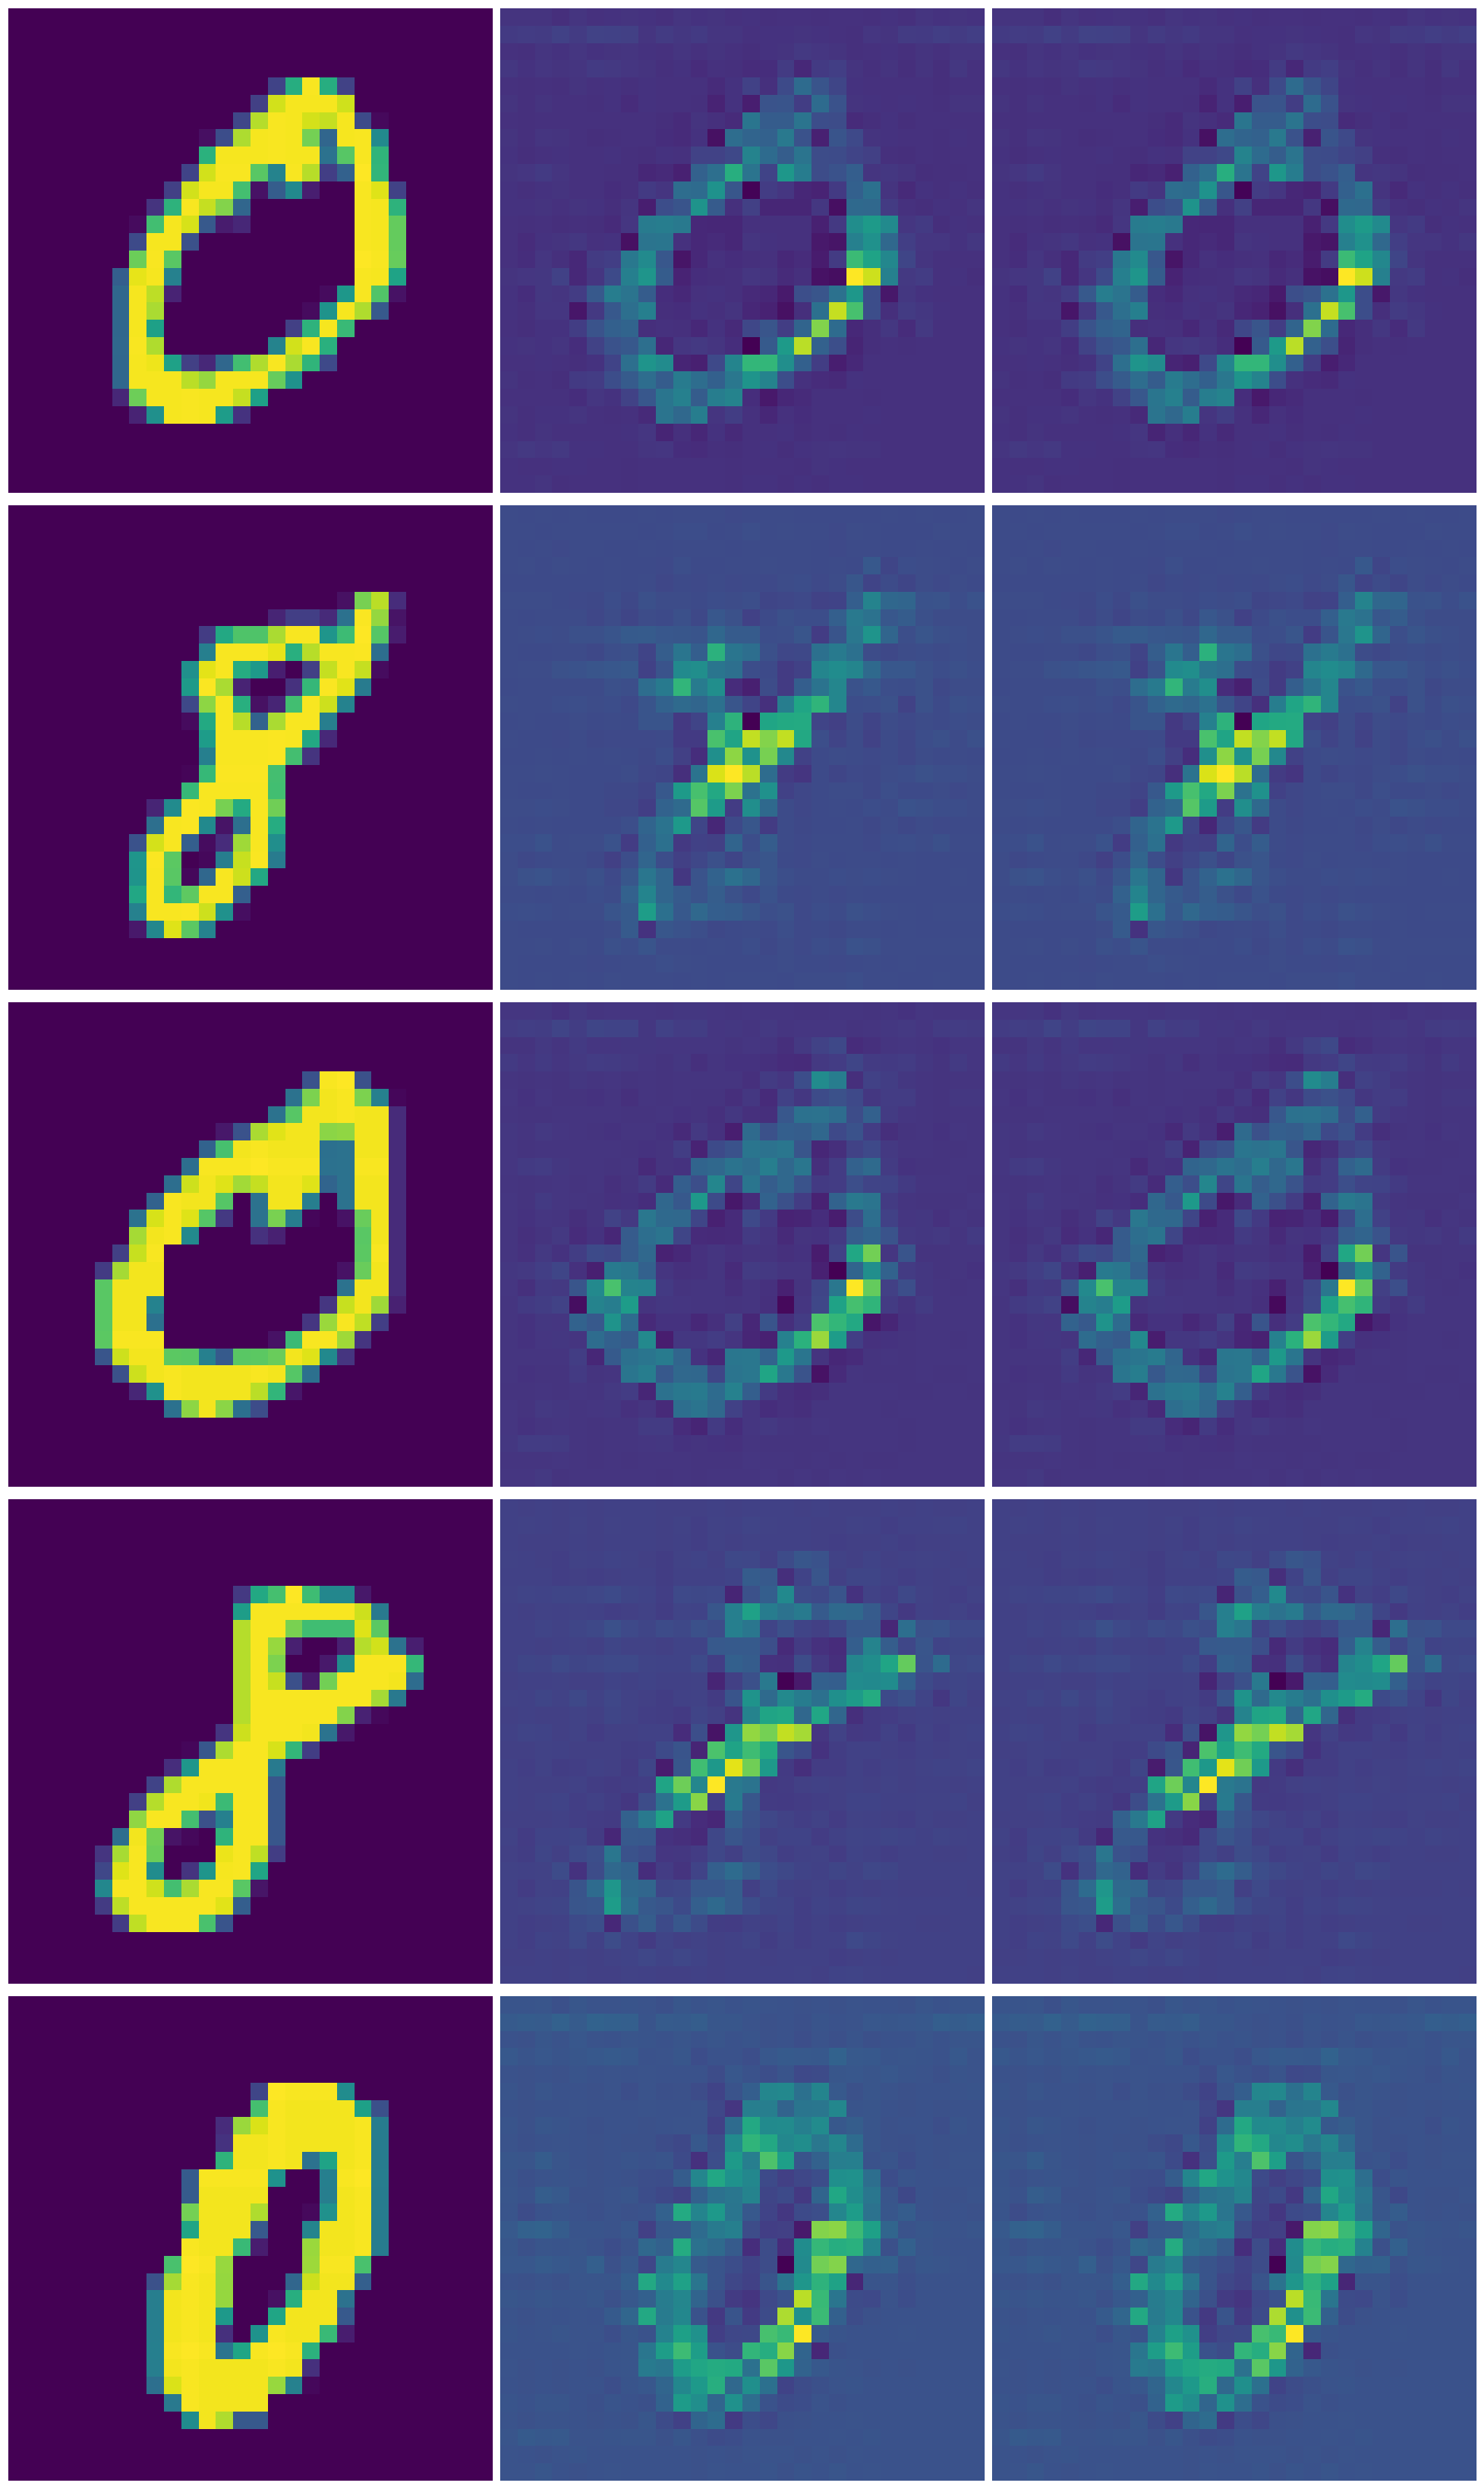

In [81]:
columns = [
    x_batch[:, 0].cpu(),
    guided_backprop_result[:, 0].cpu(),
    guided_backprop_result[:, 0].cpu()
]
titles = None
XILUtils.plot_three_columns(plt, columns, 5, titles)

In [82]:
target_layers = [model.features[3]]
guided_gracam_result = XILUtils.guided_gradcam_explain(x_batch, y_batch, model, device, target_layers)

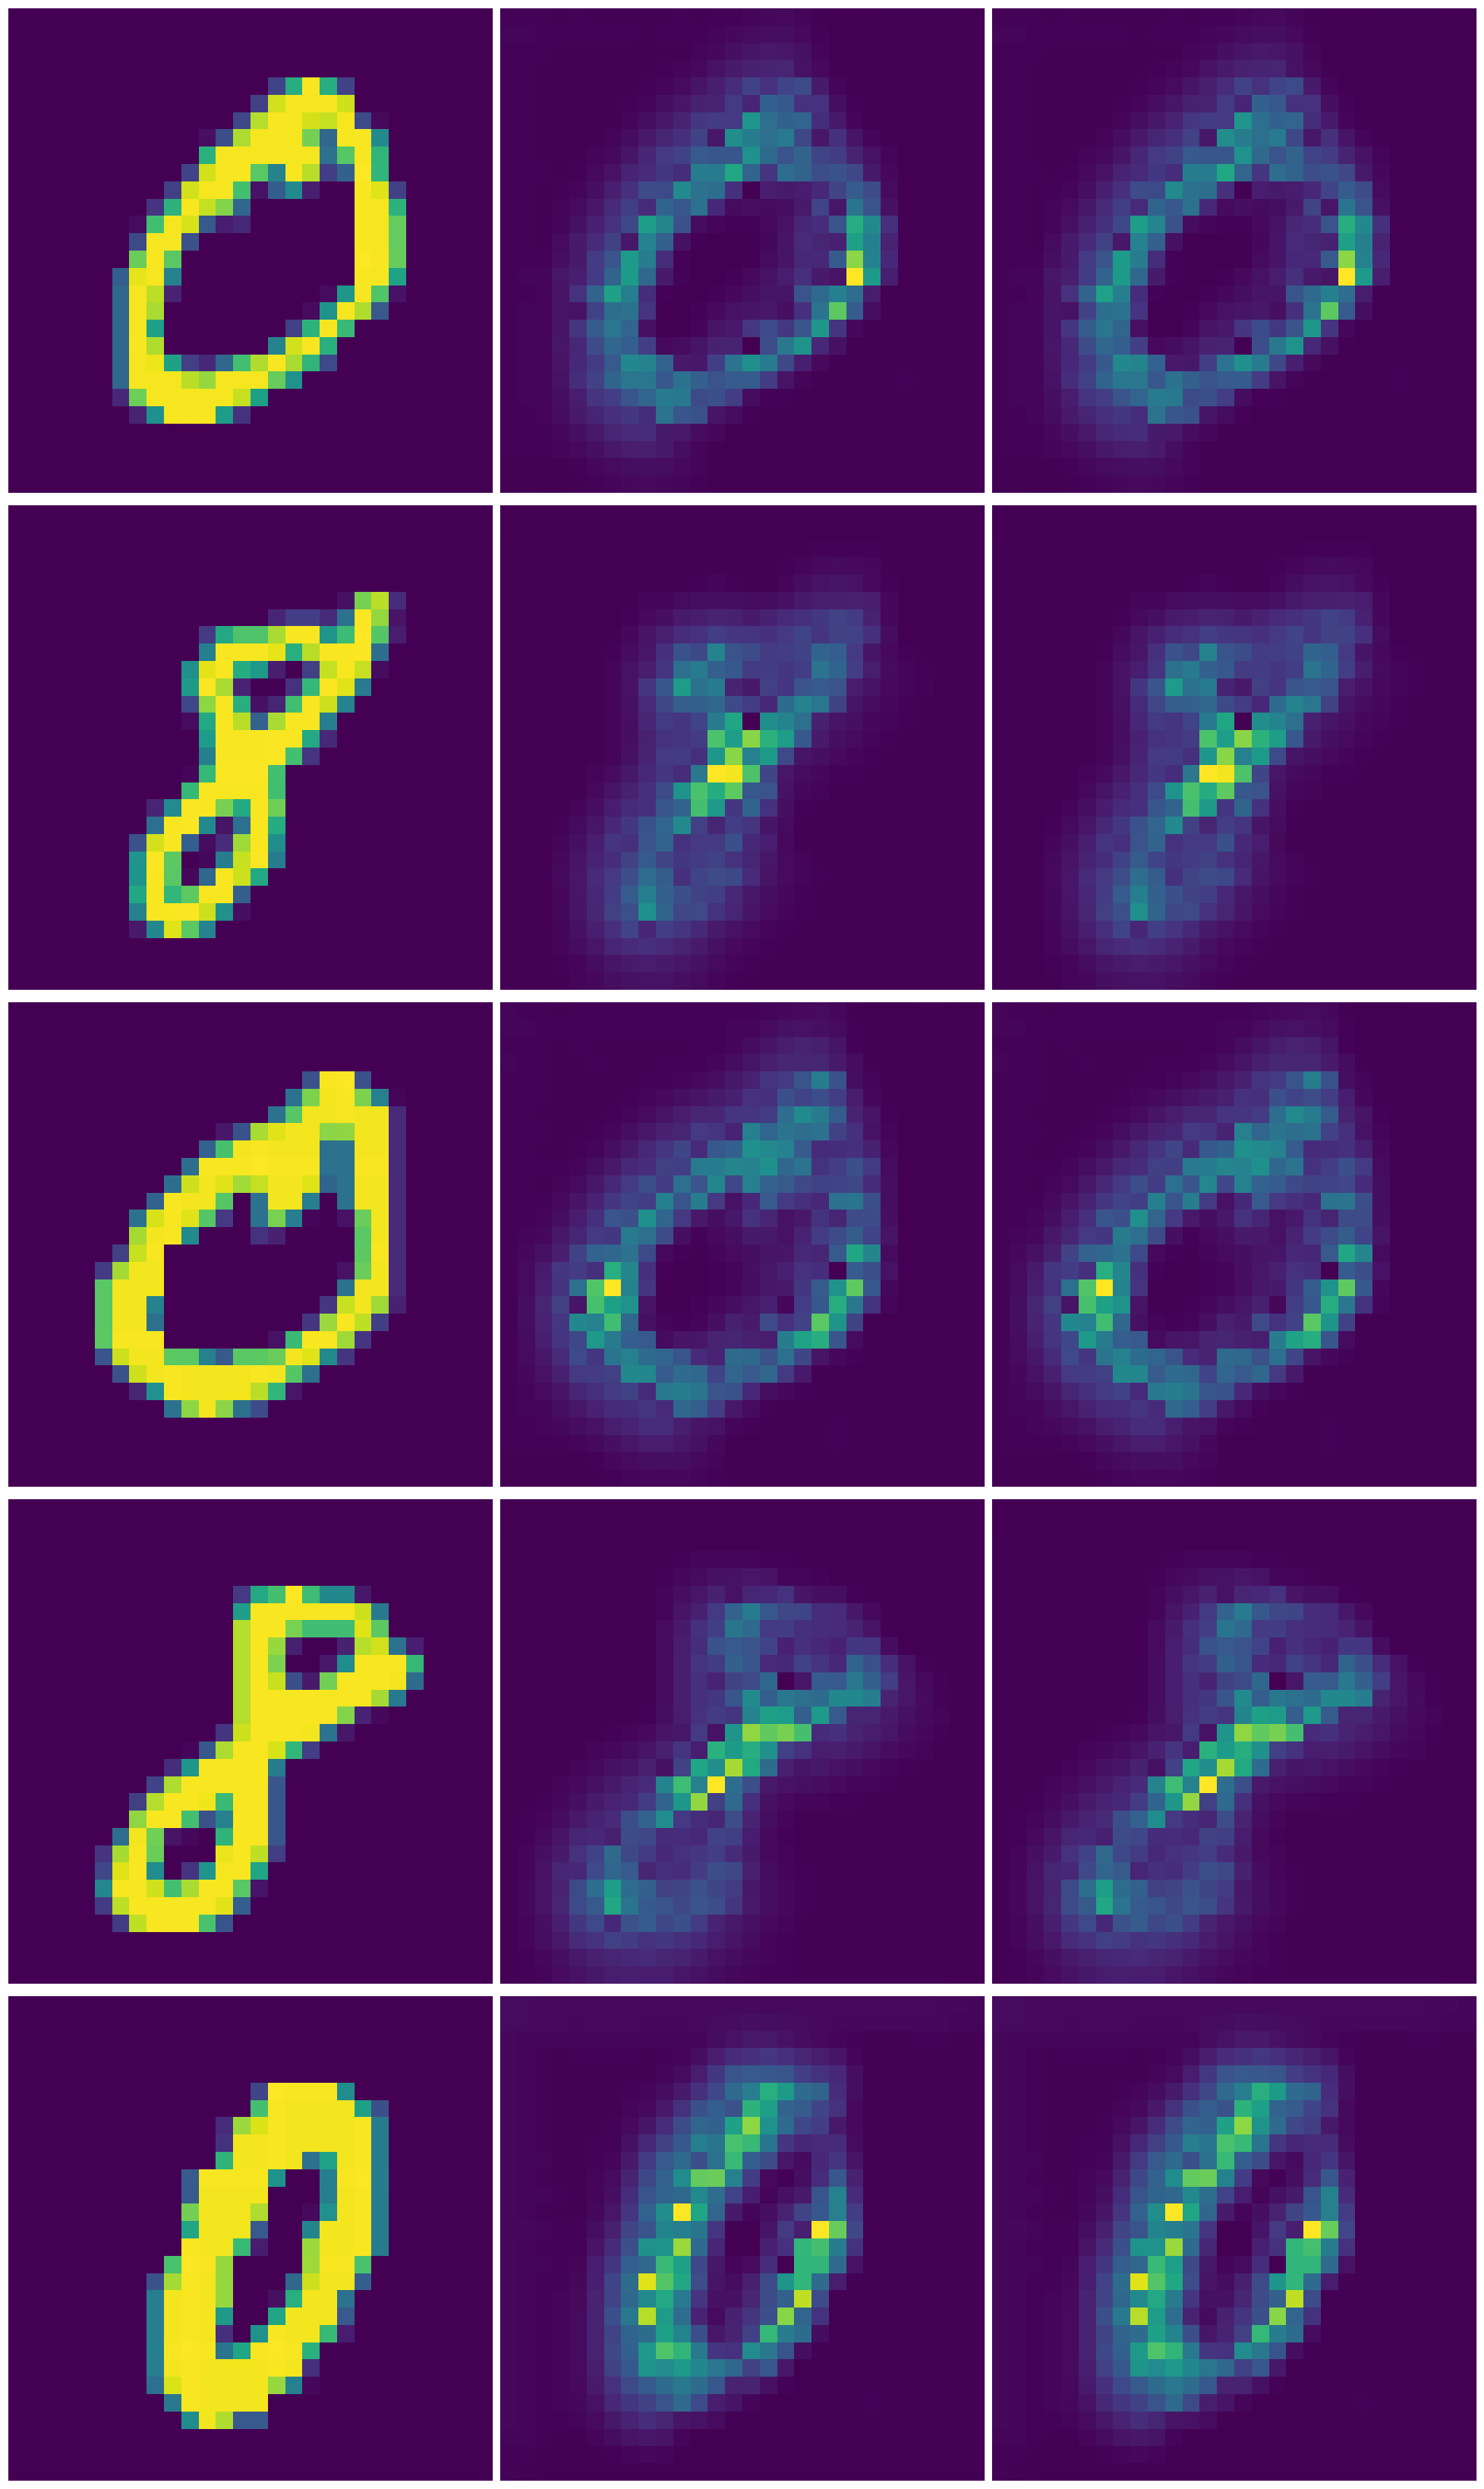

In [83]:
columns = [
    x_batch[:, 0].cpu(),
    guided_gracam_result[:, 0].cpu(),
    guided_gracam_result[:, 0].cpu()
]
titles = None
XILUtils.plot_three_columns(plt, columns, 5, titles)


In [84]:

gradcam_result = XILUtils.gradcam_explain(x_batch, model, device, target_layers)

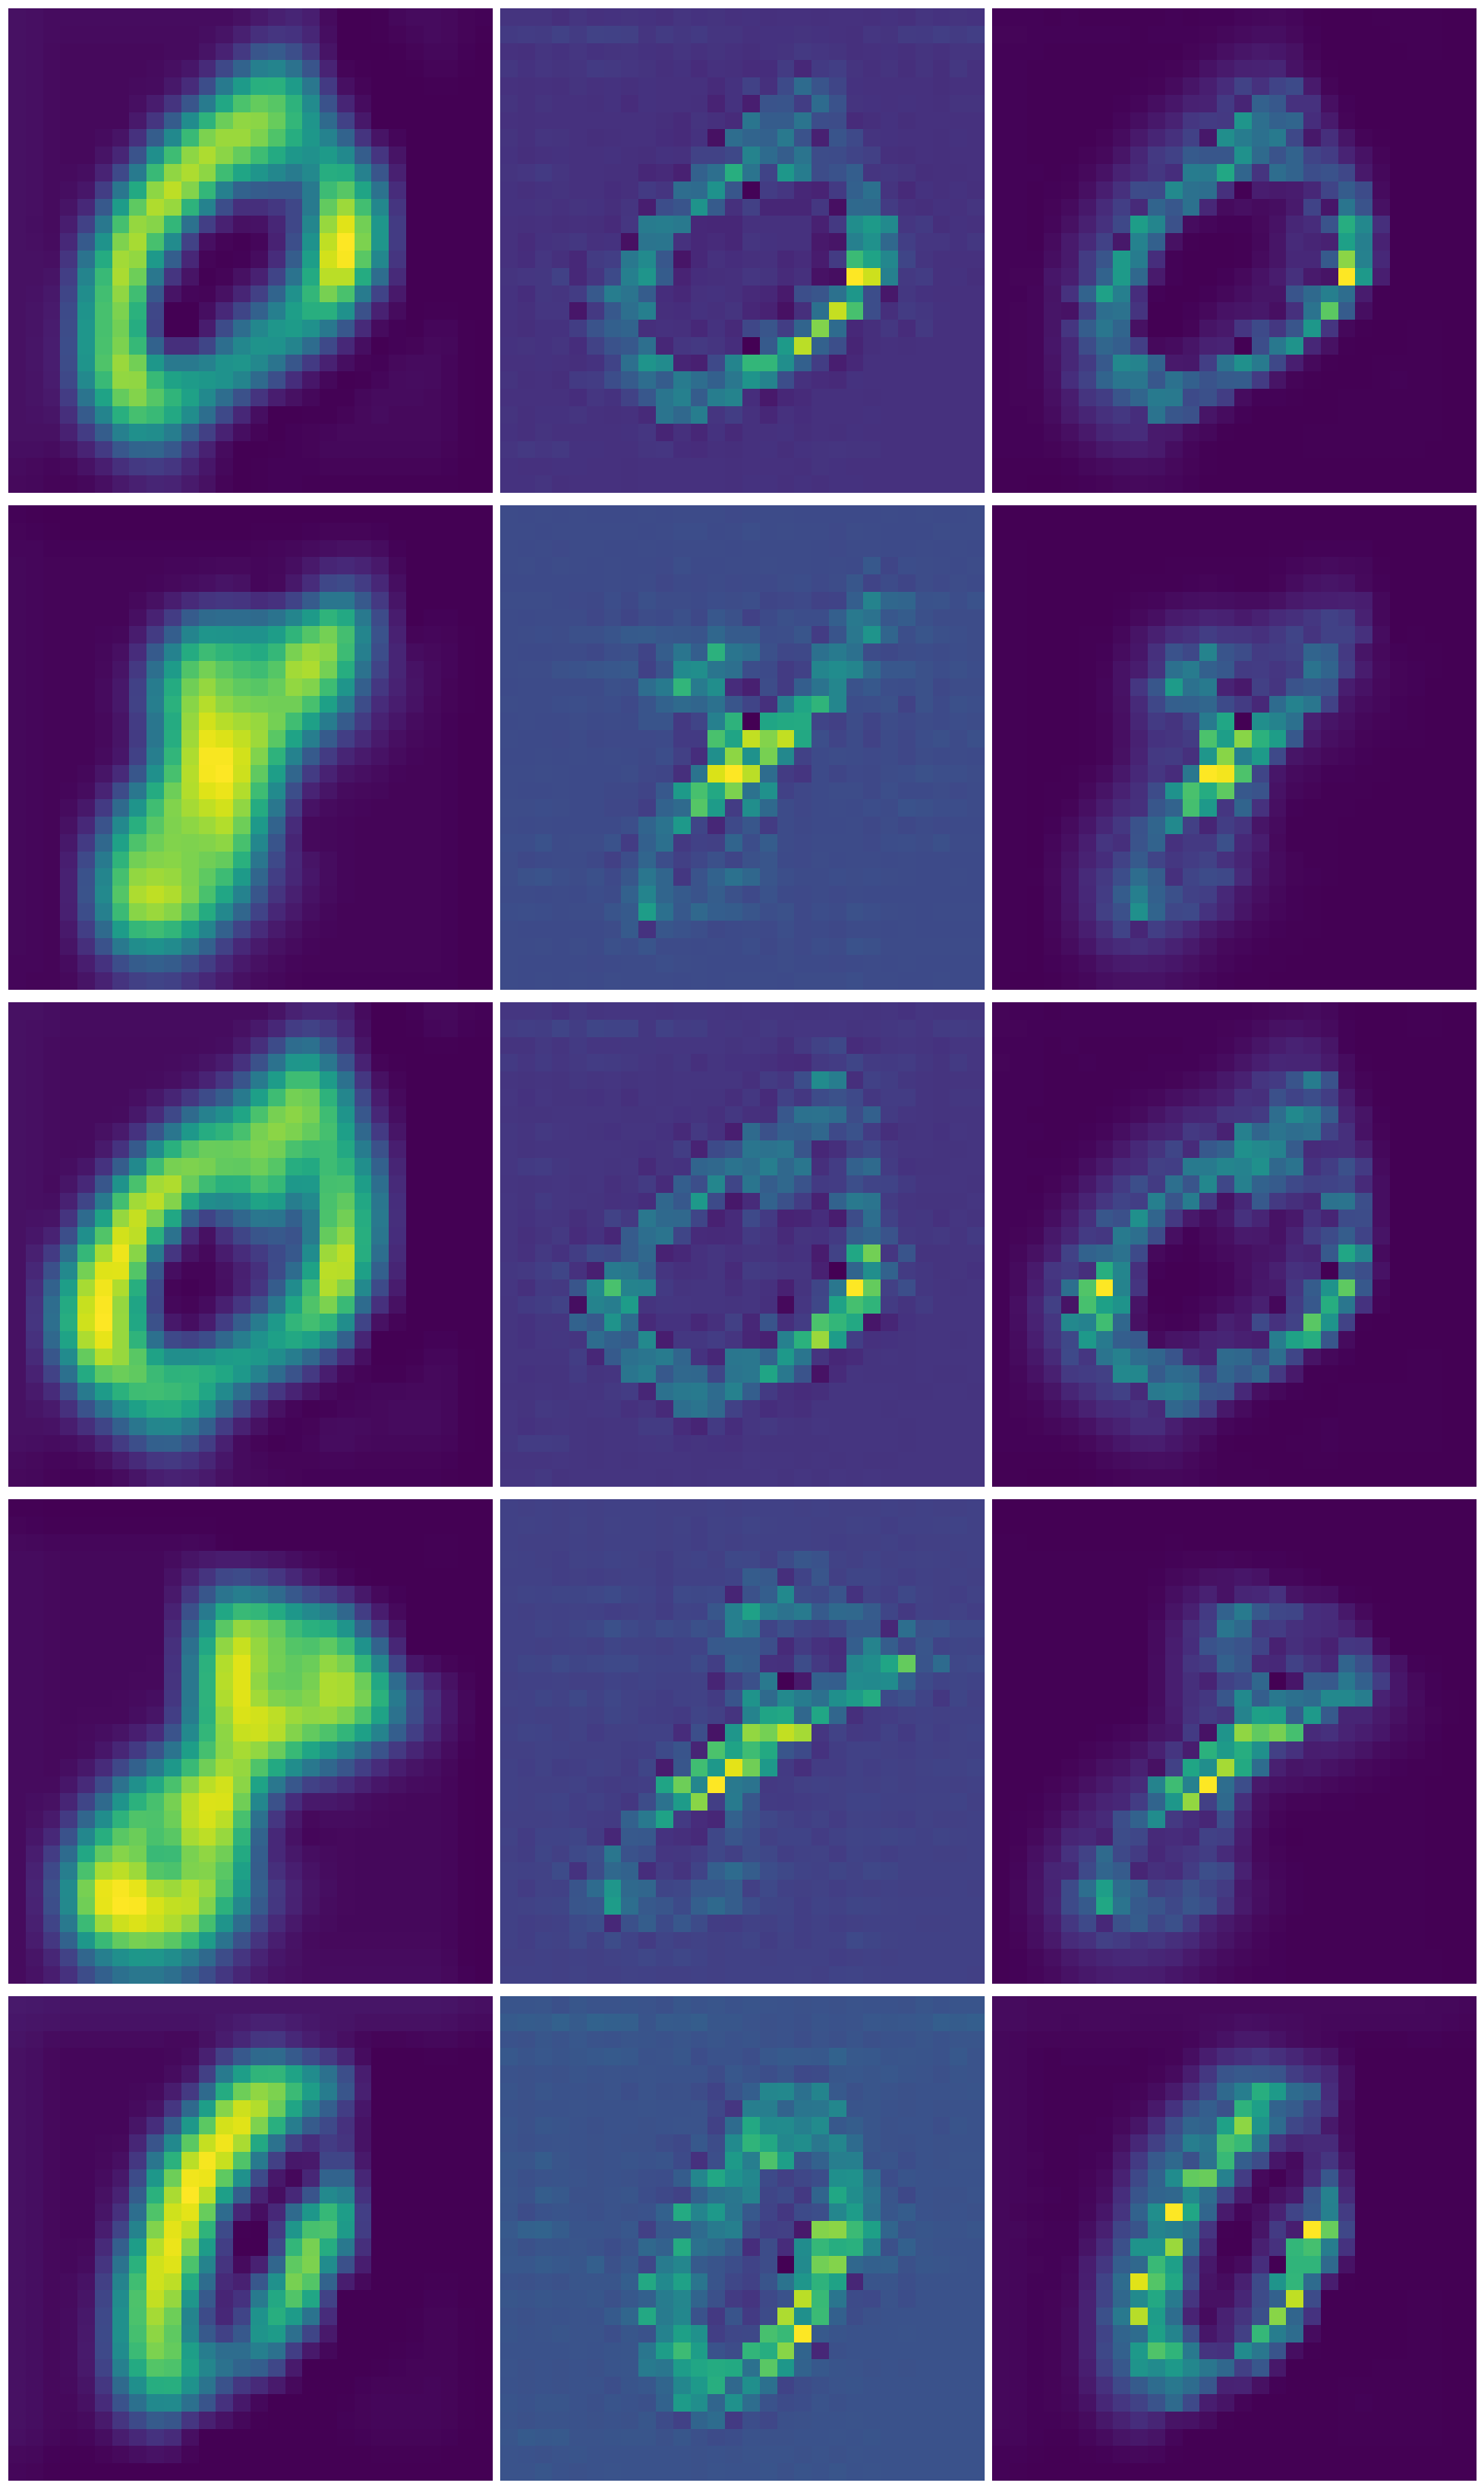

In [85]:
columns = [
    gradcam_result[:, 0].cpu(),
    guided_backprop_result[:, 0].cpu(),
    guided_gracam_result[:, 0].cpu()
]
titles = None
XILUtils.plot_three_columns(plt, columns, 5, titles)


In [52]:

y_batch
for i in y_batch.argmax(dim=-1):
    print(i)

tensor i64 mps:0 0
tensor i64 mps:0 1
tensor i64 mps:0 0
tensor i64 mps:0 1
tensor i64 mps:0 0


In [55]:

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
targets_criterium = [ClassifierOutputTarget(1) for category in y_batch.argmax(dim=-1)]

gradcam_result = XILUtils.gradcam_explain(x_batch, model, device, target_layers, target_classification_criterium=targets_criterium)



### Debugging series of `apply_gradcam` and `apply_and_show_gradcam`


Example 0:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [1.000, 0.]
Predicted target: tensor[2] i64 μ=0.500 σ=0.707 mps:0 [1, 0] with 100.000% certainty. Correct? True

Example 1:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 mps:0 [0., 1.000]
Predicted target: tensor[2] i64 μ=0.500 σ=0.707 mps:0 [0, 1] with 100.000% certainty. Correct? True


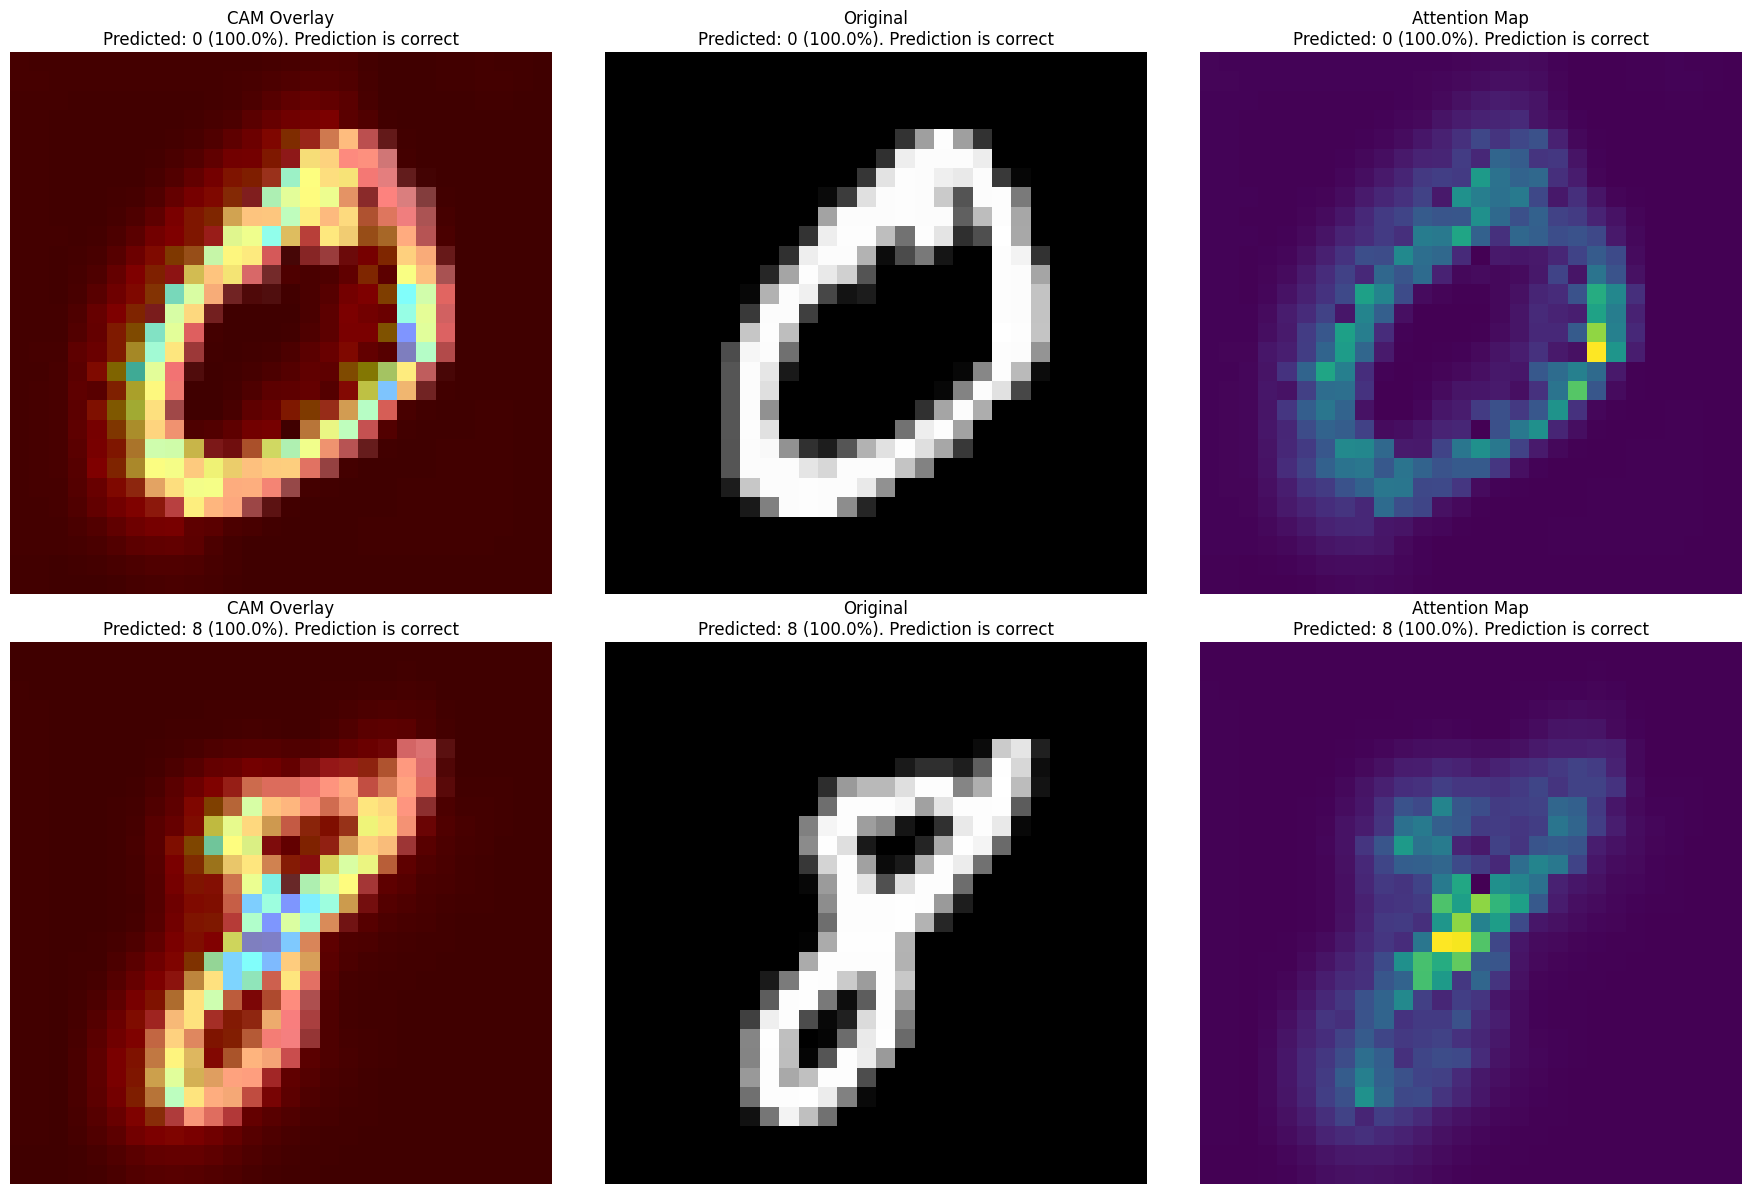

In [73]:
labels = [0, 8]
XILUtils.apply_and_show_gradcam(model, target_layers, ds_train, labels, plt,
                                batch_size=2, device=torch.device("mps"), guided_gradcam=True)
